# Simple Harmonic Oscillator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
%matplotlib inline

We would like to solve the equations of motion for a particle of mass m under the harmonic potential. First we will investigate the analytical solution. Then, we will use the Verlet algorithm which we built previously. Finally, we will try to interpolate the given data set.

First, we would like to build the problem analytically, then try to interpret the data we are provided with. We have a particle of mass m under the harmonic potential whose position and velocity is determined as below.

$$x(t) = x(0) \cos(\omega t)$$
$$\dot x(t) = -\omega x(0)\sin(\omega t)$$

The total energy is given by $E = K + U $ where $K = \frac{1}{2} m \dot x^2(t)$ and $U = \frac{1}{2} m \omega^2 x^2(t) $. By the conservation of energy, we know that $E$ is constant over time.

## Analytical Solution

In [2]:
# Building the problem analytically

x0, v0, m, k = 1, 0, 1, 1 
w = (k/m)**0.5
t = np.linspace(0,20,100)
x = x0*np.cos(w*t)
v = -x0*w*np.sin(w*t)
U = 0.5*k*x**2
K = 0.5*m*v**2
E = K + U

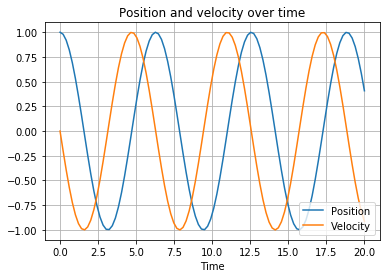

In [3]:
# Plot the position and velocity over time

plt.plot(t,x,label="Position")
plt.plot(t,v,label="Velocity")
plt.title("Position and velocity over time")
plt.xlabel("Time")
plt.grid()
plt.legend(loc="lower right")
plt.show()

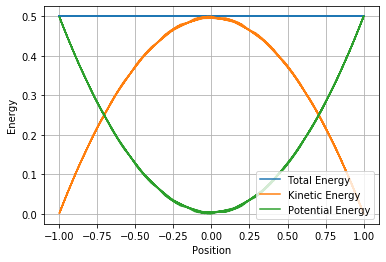

In [4]:
# Plot the energy over position

plt.plot(x,E,label="Total Energy")
plt.plot(x,K,label="Kinetic Energy")
plt.plot(x,U,label="Potential Energy")
plt.xlabel('Position')
plt.ylabel('Energy')
plt.grid()
plt.legend(loc="lower right")
plt.show()

## Verlet Algorithm

We use the previous function that we built

In [5]:
def Verlet (x_init,v_init,m,k,time_step,sim_time):
    """
    This function takes 6 inputs: Initial position (x_init), initial velocity (v_init), mass (m) of 
    the particle, force constant (k), time step, and the simulation time (sim_time) respectively.
    
    It returns 2 lists: The position (x) of the particle and the corresponding time interval (t)
    """
    
    x = [x_init]             # initialise the position 
    v = [v_init]             # initialise the velocity 
    t = [0]                  # initialise the time 
    dt = time_step
    global time
    time = sim_time
    global omega
    omega = (k/m)**0.5       # define omega
    
    i = 0                    # initialise iteration variable 
    
    for i in range(int(time/dt)+1):                    # iterate until the desired simulation time is reached 
        
        a = -(omega**2) * x[i]                       # define acceleration 
        
        if i == 0:            # we need at least two values of x to use the integrator
                              # this if condition generates the second value by using a basic Taylor approximation
            
            x_inc = x[i] + dt*v[i] + 0.5*(dt)**2 * a           # Taylor expansion
            
        else:             # use Verlet integrator
            
            x_inc = 2*x[i] - x[i-1] + (dt)**2 * a
            
        x.append(x_inc)     # append the incremented value of x to the existing list
        t.append(t[i]+dt)   # append the incremented value of t to the existing list
        
    return(x,t)             # return position and time

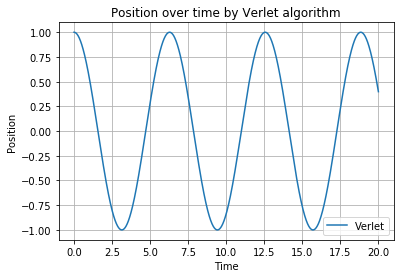

In [6]:
x_verlet,t_verlet = Verlet(1,0,1,1,0.01,20)
plt.plot(t_verlet,x_verlet,label="Verlet")
plt.title("Position over time by Verlet algorithm")
plt.xlabel("Time")
plt.ylabel("Position")
plt.grid()
plt.legend(loc="lower right")
plt.show()

## Interpolation

Now, we create a text file since we are required to read the data from a file eventually. In the following we create an arbitrary array which is a slightly shifted cosine function with a phase. We also create an array of ones (just to ensure that it is constant over time) which corresponds to the energy. Note that these arrays will be replaced by the actual data.

In [21]:
# Creating a txt file with an arbitrary data
 
#xarray = np.linspace(-5,5,100)                 # will serve as position data
xarray = np.cos(w*t)
Earray = np.ones(len(xarray))                  # will serve as energy data which are constant w.r.t position
data = np.array([xarray, Earray])
data = data.T

# change the directory in the following line

######################################################################

datafile_path = "/Users/utkugurel/Desktop/M1_Internship/datafile.txt"

######################################################################


with open(datafile_path, 'w+') as datafile_id:
    np.savetxt(datafile_id, data, fmt=['%.6f','%.6f'])


Read the data from a file and then evaluate the interpolating function in a desired interval. We use cubic spline interpolation in the following cell.

In [23]:
# Reading data from a file and creating the interpolating function

x_data = np.loadtxt("datafile.txt")[:,0]       # first column contains the position
E_data = np.loadtxt("datafile.txt")[:,1]       # second column contains the energy

#f = interpolate.CubicSpline(x_data,E_data)     # this is our interpolating function

f = interpolate.interp1d(x_data,E_data,kind="cubic",fill_value="extrapolate")  

In [31]:
# Evaluation of the interpolating function in a new interval (x_new) in which we want to extrapolate the energy

#x_new = np.linspace(5,10,len(x_data))          # new interval 
t2 = np.linspace(20,30,100)
x_new = np.cos(w*t2)
E_new = f(x_new)                               # extrapolated energy 


Now we try to calculate the derivative of energy with respect to position in the interpolated region by using the previously defined function.

In [32]:
def derive(f,x):
    """
    This function returns the first derivative of f with respect to x defined in interval [a,b]
    """
    
    g = np.zeros(len(x))       # initialisation of the list
    
    for i in range(1,len(x)-1):                      # computing the derivative except for the end points
        g[i] = (f[i+1] - f[i-1]) / (x[i+1] - x[i-1]) # difference in x is constant in this case; however, I keep it general

    g[0] = (f[1] - f[0]) / (x[1] - x[0])             # computing the derivative for the end points using forward difference
    g[-1] = (f[-1] - f[-2]) / (x[-1] - x[-2])
    
    return g

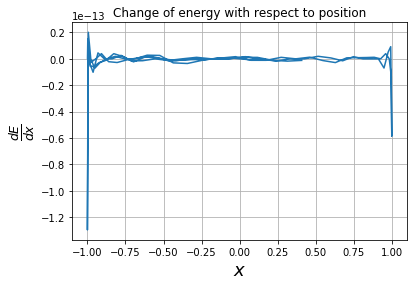

In [33]:
E_derive = derive(E_new,x_new)
plt.plot(x_new,E_derive)
plt.title("Change of energy with respect to position")
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$\\frac{dE}{dx}$",fontsize=18)
plt.grid()
plt.show()

# Update

Now we will try to compute the forces using the interpolated curve and then solve the equation of motion. We are given the position and the total energy and we interpolated that data. Now, we can compute the potential and consequently the force.

In [71]:
V_new = E_new - 0.5*m*(derive(x_new,t2))**2
F_new = -derive(V_new,x_new)
#F_new2 = -k*x_new                            # used to compute the error between F_new

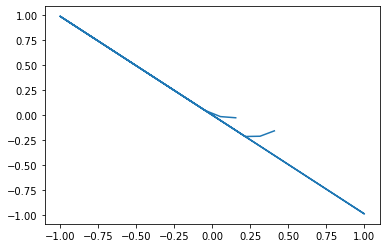

In [72]:
plt.plot(x_new,F_new)

We solved for the forces, so we can solve the equation of motion by Verlet algorithm.

In [73]:
v_new = derive(x_new,t2)
x_new_verlet,t_new_verlet = Verlet(x_new[0],v_new[0],1,1,0.01,20)

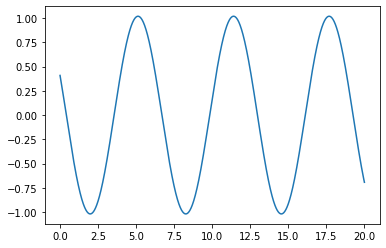

In [74]:
plt.plot(t_new_verlet,x_new_verlet)

### A small comment and a question

The function Verlet() uses the definition of acceleration for SHO, namely $a = -\frac{k}{m} x$. This causes an ambiguity when we want to compute the force. So, I will update the function so that the force can be calculated inside the function and the new acceleration will be defined as $a = \frac{F}{m}$ where $F = -\frac{dV}{dx}$

Q: As I understand correctly, we will be provided with the position and the total energy of the particle in the data set. So, can we calculate the potential by $V = E - K$? We will need to calculate the first derivative of position to compute $K$ in this case.